# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
%matplotlib inline

import warnings
from datetime import datetime
import os
from pathlib import Path
import quandl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
from pyfinance.ols import PandasRollingOLS
from sklearn.feature_selection import mutual_info_classif

In [2]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../../data/create_datasets.ipynb) in the [data](../../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [3]:
DATA_STORE = '../../data/assets.h5'

In [4]:
with pd.HDFStore(DATA_STORE) as store:
    prices = store['quandl/wiki/prices'].loc[idx['2000':'2018', :], 'adj_close'].unstack('ticker')
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [5]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

Get tickers with both price information and metdata

In [6]:
shared = prices.columns.intersection(stocks.index)

In [7]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2289 entries, A to ZUMZ
Data columns (total 3 columns):
marketcap    2287 non-null object
ipoyear      1002 non-null float64
sector       2248 non-null object
dtypes: float64(1), object(2)
memory usage: 71.5+ KB


In [8]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2289 entries, A to ZUMZ
dtypes: float64(2289)
memory usage: 82.2 MB


In [9]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [10]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [11]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 381505 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
return_1m     381505 non-null float64
return_2m     381505 non-null float64
return_3m     381505 non-null float64
return_6m     381505 non-null float64
return_9m     381505 non-null float64
return_12m    381505 non-null float64
dtypes: float64(6)
memory usage: 18.9+ MB


## Drop stocks with less than 10 yrs of returns

In [12]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345502 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
return_1m     345502 non-null float64
return_2m     345502 non-null float64
return_3m     345502 non-null float64
return_6m     345502 non-null float64
return_9m     345502 non-null float64
return_12m    345502 non-null float64
dtypes: float64(6)
memory usage: 17.2+ MB


In [13]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,345502.000000,345502.000000,345502.000000,345502.000000,345502.000000,345502.000000
mean,0.012353,0.009353,0.008338,0.007200,0.006731,0.006475
std,0.113467,0.080550,0.066075,0.048059,0.039555,0.034491
min,-0.327398,-0.253506,-0.212981,-0.160337,-0.130775,-0.112947
25%,-0.046028,-0.030347,-0.023647,-0.014607,-0.010836,-0.008764
50%,0.009524,0.009820,0.009832,0.009467,0.009105,0.008852
75%,0.065875,0.049190,0.042032,0.031989,0.027203,0.024636
max,0.428725,0.279875,0.220522,0.153314,0.123776,0.105675


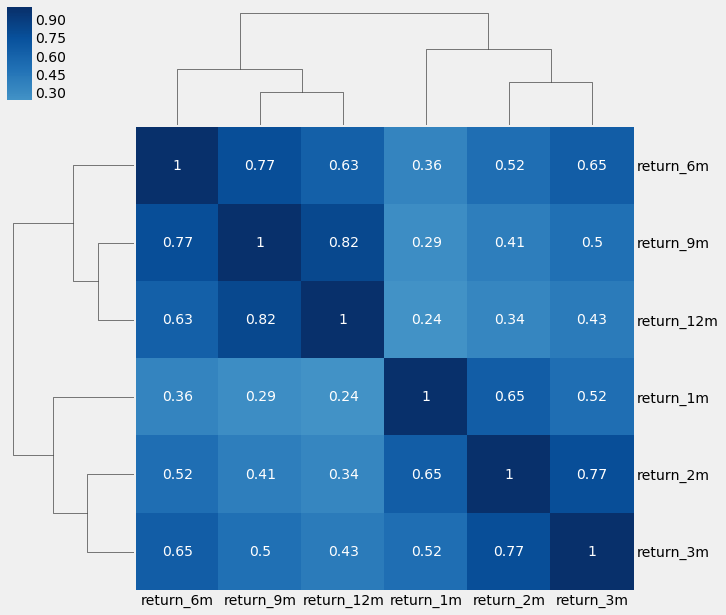

In [14]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,775 tickers.

In [15]:
data.index.get_level_values('ticker').nunique()

1756

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 8, Time Series Models]([](../../08_time_series_models)).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `PandasRollingOLS` rolling linear regression functionality in the `pyfinance` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [16]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 230 entries, 2000-01-31 to 2019-02-28
Freq: M
Data columns (total 5 columns):
Mkt-RF    230 non-null float64
SMB       230 non-null float64
HML       230 non-null float64
RMW       230 non-null float64
CMA       230 non-null float64
dtypes: float64(5)
memory usage: 10.8 KB


In [17]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345502 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 6 columns):
Mkt-RF       345502 non-null float64
SMB          345502 non-null float64
HML          345502 non-null float64
RMW          345502 non-null float64
CMA          345502 non-null float64
return_1m    345502 non-null float64
dtypes: float64(6)
memory usage: 17.2+ MB


In [18]:
T = 24
betas = (factor_data
         .groupby(level='ticker', group_keys=False)
         .apply(lambda x: PandasRollingOLS(window=min(T, x.shape[0]-1), y=x.return_1m, x=x.drop('return_1m', axis=1)).beta))

In [19]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,total
count,305114.000000,305114.000000,305114.000000,305114.000000,305114.000000,305114.000000
mean,0.979211,0.624869,0.128957,-0.061538,0.017315,1.688816
std,0.911302,1.250830,1.569375,1.995244,2.182142,3.591829
min,-9.250214,-10.248056,-15.383714,-26.090632,-18.445731,-37.529387
25%,0.461364,-0.117809,-0.691242,-0.998343,-1.086057,-0.141855
50%,0.929989,0.542886,0.103899,0.047608,0.043913,1.637183
75%,1.446082,1.301350,0.930312,0.986083,1.144610,3.517309
max,10.428027,10.351943,13.129851,18.378405,16.423135,35.902406


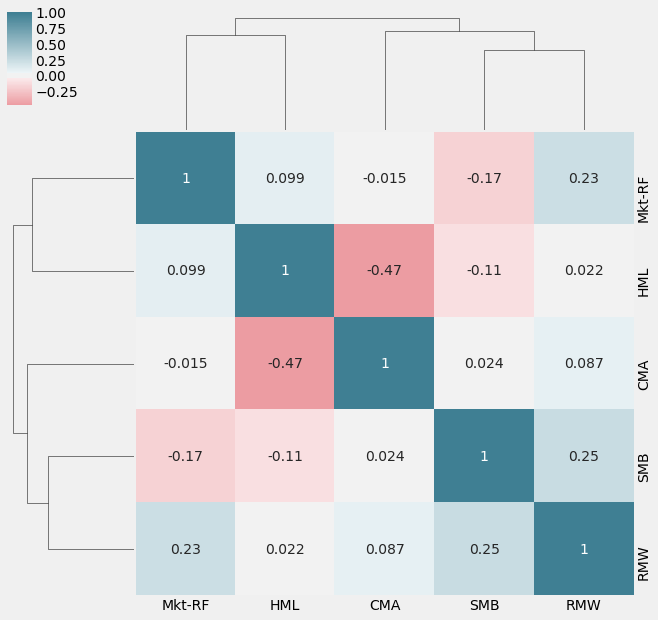

In [20]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [21]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345502 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 11 columns):
return_1m     345502 non-null float64
return_2m     345502 non-null float64
return_3m     345502 non-null float64
return_6m     345502 non-null float64
return_9m     345502 non-null float64
return_12m    345502 non-null float64
Mkt-RF        303358 non-null float64
SMB           303358 non-null float64
HML           303358 non-null float64
RMW           303358 non-null float64
CMA           303358 non-null float64
dtypes: float64(11)
memory usage: 40.3+ MB


### Impute mean for missing factor betas

In [22]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345502 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 11 columns):
return_1m     345502 non-null float64
return_2m     345502 non-null float64
return_3m     345502 non-null float64
return_6m     345502 non-null float64
return_9m     345502 non-null float64
return_12m    345502 non-null float64
Mkt-RF        345502 non-null float64
SMB           345502 non-null float64
HML           345502 non-null float64
RMW           345502 non-null float64
CMA           345502 non-null float64
dtypes: float64(11)
memory usage: 40.3+ MB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [23]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [24]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [25]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345502 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 25 columns):
return_1m        345502 non-null float64
return_2m        345502 non-null float64
return_3m        345502 non-null float64
return_6m        345502 non-null float64
return_9m        345502 non-null float64
return_12m       345502 non-null float64
Mkt-RF           345502 non-null float64
SMB              345502 non-null float64
HML              345502 non-null float64
RMW              345502 non-null float64
CMA              345502 non-null float64
momentum_2       345502 non-null float64
momentum_3       345502 non-null float64
momentum_6       345502 non-null float64
momentum_9       345502 non-null float64
momentum_12      345502 non-null float64
momentum_3_12    345502 non-null float64
year             345502 non-null int64
month            345502 non-null int64
return_1m_t-1    343746 non-null float64
return_1m_t-2    341990 non-n

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [26]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [27]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.327398      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.327398  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345502 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 30 columns):
return_1m        345502 non-null float64
return_2m        345502 non-null float64
return_3m        345502 non-null float64
return_6m        345502 non-null float64
return_9m        345502 non-null float64
return_12m       345502 non-null float64
Mkt-RF           345502 non-null float64
SMB              345502 non-null float64
HML              345502 non-null float64
RMW              345502 non-null float64
CMA              345502 non-null float64
momentum_2       345502 non-null float64
momentum_3       345502 non-null float64
momentum_6       345502 non-null float64
momentum_9       345502 non-null float64
momentum_12      345502 non-null float64
momentum_3_12    345502 non-null float64
year             345502 non-null int64
month            345502 non-null int64
return_1m_t-1    343746 non-null float64
return_1m_t-2    341990 non-n

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [29]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [30]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2289 entries, A to ZUMZ
Data columns (total 3 columns):
marketcap    2287 non-null object
ipoyear      1002 non-null float64
sector       2248 non-null object
dtypes: float64(1), object(2)
memory usage: 151.5+ KB


Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [37]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Freq: -1M
Columns: 1756 entries, A to UFS
dtypes: float64(1756)
memory usage: 2.8 MB


In [38]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [39]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [40]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345502 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 33 columns):
return_1m        345502 non-null float64
return_2m        345502 non-null float64
return_3m        345502 non-null float64
return_6m        345502 non-null float64
return_9m        345502 non-null float64
return_12m       345502 non-null float64
Mkt-RF           345502 non-null float64
SMB              345502 non-null float64
HML              345502 non-null float64
RMW              345502 non-null float64
CMA              345502 non-null float64
momentum_2       345502 non-null float64
momentum_3       345502 non-null float64
momentum_6       345502 non-null float64
momentum_9       345502 non-null float64
momentum_12      345502 non-null float64
momentum_3_12    345502 non-null float64
year             345502 non-null int64
month            345502 non-null int64
return_1m_t-1    343746 non-null float64
return_1m_t-2    341990 non-n

## Store data

We will use the data again in several later chapters, starting in [Chapter 6 on Linear Models](../../06_machine_learning_process/02_mutual_information/mutual_information.ipynb).

In [42]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../../data/assets.h5
/engineered_features            frame        (shape->[343746,33])  
/fred/assets                    frame        (shape->[4826,5])     
/quandl/wiki/prices             frame        (shape->[15389314,12])
/quandl/wiki/stocks             frame        (shape->[1,2])        
/sp500/prices                   frame        (shape->[37721,5])    
/sp500/stocks                   frame        (shape->[1,7])        
/us_equities/stocks             frame        (shape->[1,6])        


## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [43]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 345502 entries, (A, 2001-01-31 00:00:00) to (ZUMZ, 2018-03-31 00:00:00)
Data columns (total 88 columns):
return_1m                345502 non-null float64
return_2m                345502 non-null float64
return_3m                345502 non-null float64
return_6m                345502 non-null float64
return_9m                345502 non-null float64
return_12m               345502 non-null float64
Mkt-RF                   345502 non-null float64
SMB                      345502 non-null float64
HML                      345502 non-null float64
RMW                      345502 non-null float64
CMA                      345502 non-null float64
momentum_2               345502 non-null float64
momentum_3               345502 non-null float64
momentum_6               345502 non-null float64
momentum_9               345502 non-null float64
momentum_12              345502 non-null float64
momentum_3_12            345502 non-null float64
return_1m_t-